In [1]:
import librosa
import math
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.signal as sg
import re
from scipy.fftpack import dct
from scipy.fftpack import fft
from scipy.fftpack import ifft
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# calculo o do MFCC medio para cada audio de entrada
def calc_mfcc(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.mfcc(y=av, sr=sr, n_mfcc=24).T,axis=0)

In [3]:
# divisao dos audios de entrada para separacao de cada letra
def extract_intervals(signal, cut):
    data_interval = []
    interval = int(len(signal) // cut)
    for i in range(0, cut) :
        data_interval.append(pd.Series(signal[i*interval : (i+1)*interval]))
    return data_interval

In [4]:
# calculo do sinal filtrado po filtro passa-baixas de ButterWorth
def lowPassFilter(signal):
    N  = 5   # Filter order
    Wn = 0.5 # Cutoff frequency
    B, A = sg.butter(N, Wn, output='ba')
    smooth_data = sg.filtfilt(B,A, signal)
    return smooth_data

In [5]:
# calculo da serie discreta de cosenos do sinal
def calc_dct(segmento):
    av = segmento.to_numpy(copy=True)
    return dct(av, type=3, n=24)

In [6]:
# calcula o Mel Spectrogram do sinal
def calc_mel(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.melspectrogram(av, sr=sr).T,axis=0)

In [7]:
# calcula a FFT do sinal
def calc_fft(segmento):
    av = segmento.to_numpy(copy=True)
    return abs(fft(av, n=24))

In [8]:
# faz a aquisicao do caminho de todos os arquivos na pasta path
def get_files(path):
    files = glob.glob(path + "*.wav")
    return files

#quebra o nome do arquivo em letras para categorizacao dos audios
def get_labels(path_file):
    path_file = re.sub("[ (1)]", "", path_file)
    return list(path_file[-8:-4])

In [9]:
# realiza a extracao de features do sinal
def feature_extraction(segmento, sr):

    features = []
    np.array(features)
    
    features=np.append(features, calc_mfcc(segmento, sr))
    features=np.append(features, calc_mel(segmento, sr))
    features=np.append(features, calc_dct(segmento))
    features=np.append(features, calc_fft(segmento))

    return features

In [10]:
def get_x_y(path, seed=4):
    files = get_files(path)

    Xt = []
    yt = []
    segmentos = []
    # random.seed(seed)
    # random.shuffle(files)
    for f in files:
        data, sr = librosa.load(f, mono=True)
        segmentos += extract_intervals(data, 4)
        yt += get_labels(f)    

    for segmento in segmentos:
        Xt.append(feature_extraction(segmento, sr))
    
    return Xt,yt

In [11]:
def unique_values(l):
    unique_list = []
    for x in l: 
        if x not in unique_list: 
            unique_list.append(x)
    return unique_list

In [12]:
def print_conf_mtx(yt , y_pred, labels):
    cm = confusion_matrix(yt, y_pred, labels)
    
    print(cm)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.locator_params(nbins=len(labels))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [13]:
#amostras = data.shape[0]
#print(f"frequencia de amostragem = {sr}")
#print(f"quantidade de amostras = {amostras}")

In [14]:
path = 'TREINAMENTO/'
test_path = 'VALIDACAO/'

In [15]:
X, y = get_x_y(path)
Xt, yt = get_x_y(test_path)

In [16]:
svm = SVC(kernel='linear', class_weight='balanced',probability=True, gamma='auto')

In [17]:
svm.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [18]:
y_pred = svm.predict(Xt)

In [19]:
svm.score(Xt, yt)

0.5880149812734082

[[64  0  0  0 12  7  0 14  2  1]
 [ 1 80 12  0  0  4  0  0  0  0]
 [ 0 14 93  0  0  6  6  0  3  0]
 [ 4  4  1 42  6  2  2  3 44  2]
 [18  1  1  2 62 13  0  2  8  0]
 [17  2  6  1  3 79  2  1  2  1]
 [ 2  0  2 18  3  0 36  0 10 33]
 [14  0  0  0  8  2  0 67  3  1]
 [ 3  0  2 31  7  2  6  2 51  2]
 [ 2  1  0  6  1  1 40  0  8 54]]


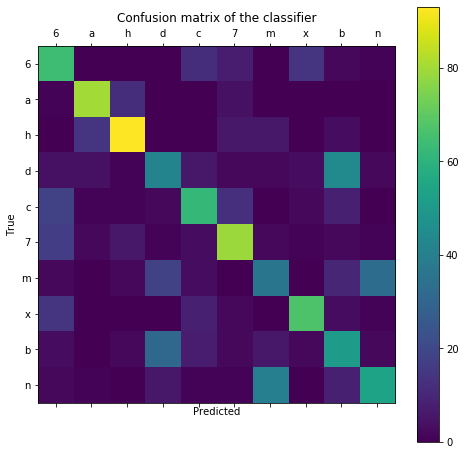

In [20]:
labels = unique_values(y)
print_conf_mtx(yt, y_pred, labels)

In [21]:
knc = KNeighborsClassifier(n_neighbors = 3, n_jobs = 3, p = 1)

In [22]:
knc.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=3, n_neighbors=3, p=1,
                     weights='uniform')

In [23]:
y_knc = knc.predict(Xt)

In [24]:
knc.score(Xt, yt)

0.5730337078651685

[[70  0  0  0 14  8  0  8  0  0]
 [ 1 77 16  1  0  0  1  0  1  0]
 [ 0 16 99  1  0  3  1  0  1  1]
 [ 3  3  0 36  5  3  5  0 52  3]
 [25  0  0  0 58 10  1  3 10  0]
 [21  1  1  0  6 83  0  2  0  0]
 [ 2  0  1 15  4  1 29  1 22 29]
 [24  0  0  0  4  5  0 61  1  0]
 [ 3  2  0 27  8  0  5  1 59  1]
 [ 2  1  0  3  3  2 39  0 23 40]]


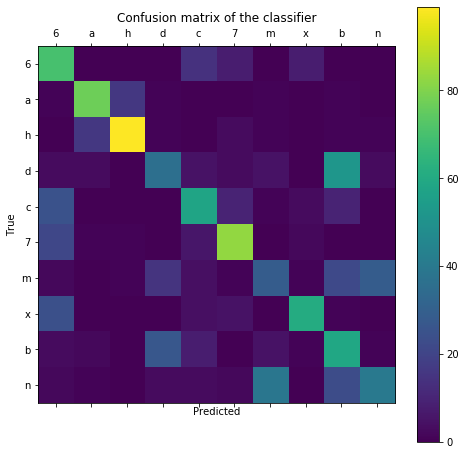

In [25]:
print_conf_mtx(yt, y_knc, labels)